In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold,cross_validate
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import itertools

In [79]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/home/pawblo/Desktop/studia/semestr3/Siwib/data/data/ae_retro_data.xlsx - Discretized.csv')
df.replace("?", np.nan, inplace=True)

# Display the first few rows of the DataFrame to ensure it's loaded correctly
df.head()

,REG_AGE,PRIM_CARE,CHEST_CLINIC,CURR_INH_STEROID,AGE_FIRST_SX,PREV_ORAL_STEROID,PREV_ED_LAST_YEAR,PREV_ADM,ENV_SMOKE,ENV_DANDER,...,REASS_SAO2,REASS_AIR_ENTRY,REASS_DISTRESS,REASS_COLOUR,REASS_EXP_WHEEZE,REASS_INSP_WHEEZE,REASS_RETRACTIONS,NUM_MASKS,CORR_CATEGORY,DECISION_OFFSET
0,GE_3Y_LT_7Y,FD,NO,NaN,GE_1Y_LT_3Y,GE_1M_LT_3M,2_VISITS,FLOOR,NaN,NaN,...,NaN,NaN,NONE,PINK,PRESENT,PRESENT,NaN,0,LONG,60
1,GE_3Y_LT_7Y,FD,NO,PRN,GE_3Y,GE_12M,NONE,NONE,NaN,NaN,...,GE_93_LT_95,GOOD,NaN,NaN,ABSENT,ABSENT,ABSENT,1,SHORT,60
2,GE_3Y_LT_7Y,FD,NO,PRN,GE_3Y,GE_12M,NONE,NONE,NaN,NaN,...,GE_95,GOOD,NaN,PINK,ABSENT,ABSENT,ABSENT,1,SHORT,120
3,GE_7Y,FD,NO,NaN,GE_1Y_LT_3Y,GE_12M,2_VISITS,NONE,YES,NO,...,NaN,GOOD,NONE,PINK,ABSENT,ABSENT,ABSENT,1,ADMIT,120
4,GE_3Y_LT_7Y,FD,YES,PRN,GE_1Y_LT_3Y,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,NaN,GOOD,NaN,NaN,ABSENT,ABSENT,PRESENT,1,SHORT,60


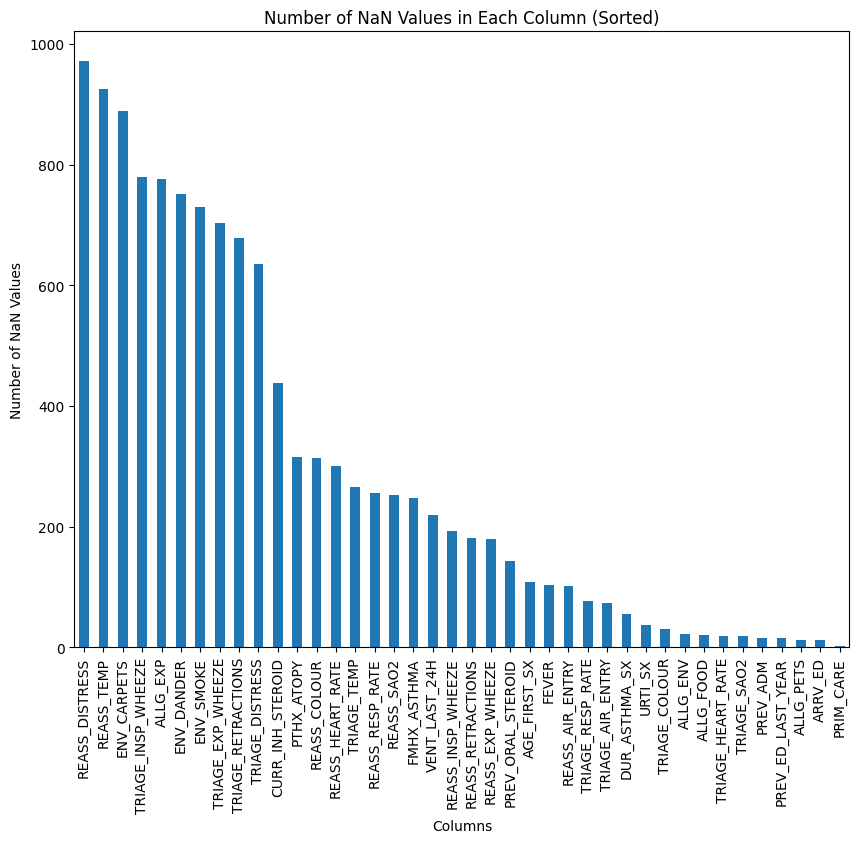

In [80]:
nan_counts = df.isna().sum()

# Filter out columns with 0 NaN values to focus on those with missing data
nan_counts = nan_counts[nan_counts > 0]
nan_counts_sorted = nan_counts.sort_values(ascending=False)

# Plotting the sorted data
plt.figure(figsize=(10, 8))
nan_counts_sorted.plot(kind='bar')
plt.title('Number of NaN Values in Each Column (Sorted)')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=90)
plt.show()

In [81]:
# Defining the decision class
df['CORR_CATEGORY'] = df['CORR_CATEGORY'].map({'LONG': 1, 'ADMIT': 1, 'SHORT': 0})

# Drop the 'DECISION_OFFSET' column
df.drop('DECISION_OFFSET', axis=1, inplace=True)

# Check the transformation and the remaining columns
df['CORR_CATEGORY'].value_counts(), df.head()

(CORR_CATEGORY
 1    653
 0    417
 Name: count, dtype: int64,
        REG_AGE PRIM_CARE CHEST_CLINIC CURR_INH_STEROID AGE_FIRST_SX   
 0  GE_3Y_LT_7Y        FD           NO              NaN  GE_1Y_LT_3Y  \
 1  GE_3Y_LT_7Y        FD           NO              PRN        GE_3Y   
 2  GE_3Y_LT_7Y        FD           NO              PRN        GE_3Y   
 3        GE_7Y        FD           NO              NaN  GE_1Y_LT_3Y   
 4  GE_3Y_LT_7Y        FD          YES              PRN  GE_1Y_LT_3Y   
 
   PREV_ORAL_STEROID PREV_ED_LAST_YEAR PREV_ADM ENV_SMOKE ENV_DANDER  ...   
 0       GE_1M_LT_3M          2_VISITS    FLOOR       NaN        NaN  ...  \
 1            GE_12M              NONE     NONE       NaN        NaN  ...   
 2            GE_12M              NONE     NONE       NaN        NaN  ...   
 3            GE_12M          2_VISITS     NONE       YES         NO  ...   
 4      GE_3M_LT_12M       GE_4_VISITS    FLOOR       NaN        NaN  ...   
 
   REASS_HEART_RATE   REASS_SAO2 REASS_

In [82]:
# Ponowne przygotowanie danych
X = df.drop('CORR_CATEGORY', axis=1)
y = df['CORR_CATEGORY']


missing_values_count = X.isnull().sum()

# Sortowanie kolumn od tych z największą liczbą brakujących wartości do najmniejszej
missing_values_count_sorted = missing_values_count.sort_values(ascending=False)

# Wybieranie 3 kolumn z największą liczbą brakujących wartości
columns_to_drop = missing_values_count_sorted.head(1).index

# Usuwanie tych kolumn z ramki danych
X = X.drop(columns=columns_to_drop)


imp = SimpleImputer(strategy="most_frequent")
X_filled = imp.fit_transform(X)
X = pd.DataFrame(X_filled, columns=X.columns)
# Przygotowanie pipeline'u
categorical_cols = X.columns
categorical_cols

Index(['REG_AGE', 'PRIM_CARE', 'CHEST_CLINIC', 'CURR_INH_STEROID',
       'AGE_FIRST_SX', 'PREV_ORAL_STEROID', 'PREV_ED_LAST_YEAR', 'PREV_ADM',
       'ENV_SMOKE', 'ENV_DANDER', 'ENV_CARPETS', 'ALLG_ENV', 'ALLG_PETS',
       'ALLG_FOOD', 'PTHX_ATOPY', 'FMHX_ASTHMA', 'ALLG_EXP', 'URTI_SX',
       'FEVER', 'DUR_ASTHMA_SX', 'VENT_LAST_24H', 'ARRV_ED', 'TRIAGE_TEMP',
       'TRIAGE_RESP_RATE', 'TRIAGE_HEART_RATE', 'TRIAGE_SAO2',
       'TRIAGE_AIR_ENTRY', 'TRIAGE_DISTRESS', 'TRIAGE_COLOUR',
       'TRIAGE_EXP_WHEEZE', 'TRIAGE_INSP_WHEEZE', 'TRIAGE_RETRACTIONS',
       'REASS_TEMP', 'REASS_RESP_RATE', 'REASS_HEART_RATE', 'REASS_SAO2',
       'REASS_AIR_ENTRY', 'REASS_COLOUR', 'REASS_EXP_WHEEZE',
       'REASS_INSP_WHEEZE', 'REASS_RETRACTIONS', 'NUM_MASKS'],
      dtype='object')

In [83]:
print(X.shape)
categorical_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_cols)
], remainder='passthrough') 
X = categorical_transformer.fit_transform(X)


(1070, 42)


In [84]:
def calculate_risk_thresholds(y: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    # sensitivity, specificity = tpr, 1 - fpr
    medium_risk = thresholds[tpr >= 0.99][0]
    high_risk = thresholds[fpr >= (1 - 0.9)][0]

    return medium_risk, high_risk

def make_prediction(y_pred_proba: np.ndarray, medium_risk: float, high_risk: float) -> np.ndarray:
    return np.array(
        [
            0 if response < medium_risk else 1 if response >= high_risk else np.nan
            for response in y_pred_proba
        ]
    )

def calculate_rates(
    y: np.ndarray, y_pred: np.ndarray, positives: float, negatives: float
) -> tuple[float, float, float, float]:
    tn, tp, fn, fp = confusion_matrix(y, y_pred).ravel()
    # positives, negatives = tp + fn, tn + fp

    tpr = tp / positives  # sensitivity
    fnr = fn / positives  # miss_rate
    fpr = fp / (fp + tn)  # fall_out
    tnr = tn / negatives  # specificity

    return tpr, fnr, fpr, tnr
def train_evaluate_classifier(classifier, X,y, name):
    auroc_scores = []
    auprc_scores = []
    medium = []
    high = []
    positives = []
    negatives = []
    fnrs = []
    fprs = []
    for _ in range(3):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random.randint(0,130))
        
        for train_index, test_index in skf.split(X, y):
           
            X_train_fold, X_val_fold = X[train_index], X[test_index]
            y_train_fold, y_val_fold = y[train_index], y[test_index]
            
            # Trenowanie modelu
            classifier.fit(X_train_fold, y_train_fold)


            # Predykcja na zbiorze walidacyjnym
            y_pred = classifier.predict(X_val_fold)
            # Obliczanie AUROC i AUPRC

            auroc = roc_auc_score(y_val_fold, y_pred)
            auprc = average_precision_score(y_val_fold, y_pred)
            auroc_scores.append(auroc)
            auprc_scores.append(auprc)

            #predykcja na zbiorze uczącym

            y_pred_proba = classifier.predict_proba(X_val_fold)[:,1]


            #fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_proba)
           # thresholds = np.flip(thresholds)
            # if np.any(tpr >= 0.99):
            #     medium_risk_threshold = thresholds[np.where(tpr >= 0.99)[0][0]]  # Używamy pierwszego progu spełniającego warunek
            # else:
            #     medium_risk_threshold = thresholds[0] 
            # specificity = 1 - fpr
            y_pred_proba_train = classifier.predict_proba(X_train_fold)[:, 1]
            medium_risk, high_risk = calculate_risk_thresholds(y_train_fold, y_pred_proba_train)
        #     if np.any(specificity >= 0.90):
        # # Szukamy pierwszego progu (w odwróconej tablicy), dla którego specificity >= 0.90
        #         high_risk_threshold = thresholds[np.where(specificity >= 0.90)[0][0]]
        #     else:
        #         # W przeciwnym wypadku wybieramy najwyższy możliwy próg (pierwszy w odwróconej tablicy)
        #         high_risk_threshold = thresholds[0]
            predicted = make_prediction(y_pred_proba, medium_risk, high_risk)
            medium.append(medium_risk)
            high.append(high_risk)
            positive = np.sum(predicted == 1)
            negative = np.sum(predicted == 0)
            unknown = np.sum(np.isnan(predicted))
            number_of_samples: int = len(X_val_fold)
            
            positives.append(positive / number_of_samples)
            negatives.append(negative / number_of_samples)
            mask = ~np.isnan(predicted)
            tpr, fnr, fpr, tnr = calculate_rates(y_val_fold[mask], predicted[mask], positive, negative)

            fnrs.append(fnr)
            fprs.append(fpr)
    return {
            f"{name}- aurocs":np.mean(auroc_scores),
            f"{name}- auprcs":np.mean(auprc_scores),
            f"{name}- positives":np.mean(positives),
            f"{name}- negatives":np.mean(negatives),
            f"{name}- fnrs":np.mean(fnrs),
            f"{name}- fprs":np.mean(fprs)
        }
    

positives

In [85]:
classifier = DecisionTreeClassifier(random_state=42, max_depth=10)
train_evaluate_classifier(classifier,X,y, "base")


{'base- aurocs': 0.6723110168493228,
 'base- auprcs': 0.7114226447091134,
 'base- positives': 0.6280373831775701,
 'base- negatives': 0.2688473520249221,
 'base- fnrs': 0.1770656709198511,
 'base- fprs': 0.7463212606388033}

In [86]:
classifier = RandomForestClassifier(random_state=42)
print(train_evaluate_classifier(classifier,X,y, "target"))

{'target- aurocs': 0.7573454284660943, 'target- auprcs': 0.7712596700230417, 'target- positives': 0.3875389408099688, 'target- negatives': 0.612461059190031, 'target- fnrs': 0.6737466428112445, 'target- fprs': 0.49749756802016226}


In [89]:
from sklearn.ensemble import RandomForestClassifier
import itertools
import numpy as np

# Załóżmy, że funkcja train_evaluate_classifier oraz zmienne X i y są już zdefiniowane w Twoim środowisku.

# Parametry do przetestowania
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Generator kombinacji parametrów
def param_combinations(params):
    keys, values = zip(*params.items())
    for v in itertools.product(*values):
        yield dict(zip(keys, v))

# Przechowywanie wyników
results = []

# Iteracja przez każdą kombinację parametrów
for params in param_combinations(param_grid):
    # Utworzenie klasyfikatora z danymi parametrami
    classifier = RandomForestClassifier(random_state=42, **params)
    # Ewaluacja klasyfikatora za pomocą Twojej funkcji
    evaluation_results = train_evaluate_classifier(classifier, X, y, "base")
    # Zapisanie wyników
    results.append({'params': params, 'evaluation_results': evaluation_results})

# Tutaj możesz wyświetlić lub przetworzyć wyniki
for result in results:
    print(result)

{'params': {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, 'evaluation_results': {'base- aurocs': 0.7281002515781323, 'base- auprcs': 0.7519052028126628, 'base- positives': 0.6317757009345795, 'base- negatives': 0.3682242990654206, 'base- fnrs': 0.19404926736437958, 'base- fprs': 0.6629379426607687}}
{'params': {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}, 'evaluation_results': {'base- aurocs': 0.7070756099924681, 'base- auprcs': 0.7334761028245135, 'base- positives': 0.6934579439252336, 'base- negatives': 0.2570093457943925, 'base- fnrs': 0.10563649126751992, 'base- fprs': 0.7386812260717686}}
{'params': {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}, 'evaluation_results': {'base- aurocs': 0.7053090071888931, 'base- auprcs': 0.7323462702432748, 'base- positives': 0.6981308411214953, 'base- negatives': 0.28878504672897193, 'base- fnrs': 0.12042219543013151, 'base- f

In [94]:
x_points=[]
y_points=[]
for res in results:
    x_points.append(res['evaluation_results']['base- aurocs']+res['evaluation_results']['base- auprcs'])
    y_points.append(res['evaluation_results']['base- fnrs']+res['evaluation_results']['base- fprs'])

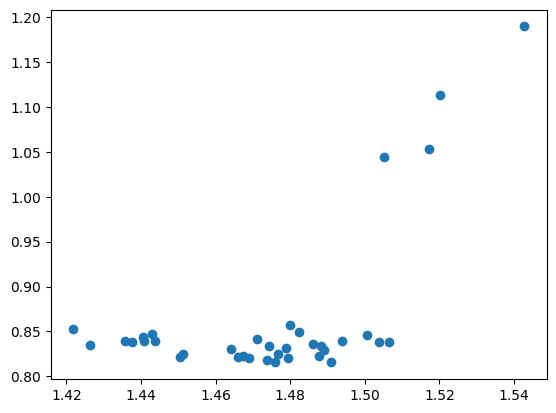

In [96]:
plt.scatter(x_points, y_points, )